# Uncover the factors to help measure how young children learn

### Setting Up

In [1]:
# File system management
import os
import gc

# Numpy and pandas for data analysis and manipulation
import numpy as np
import pandas as pd

# Json for converting string to dict
import json

# Random for random
import random

# Datetime for handling date time variables
import datetime as dt

# Matplotlib pyplot and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Algorithms
from sklearn.ensemble import RandomForestClassifier as rf
from xgboost import XGBClassifier as xgb
from lightgbm import LGBMClassifier as lgbm
from lightgbm import LGBMRegressor

# Sklearn importing folding methods
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder

# Sklearn importing evaluation metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

# Hyper paramater optimisation
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin

# Weights and Biases for model control
import wandb

# tqdm for progress management
from tqdm import tqdm

In [2]:
# Setting up
config = {
    'method': 'LightGBM',
    'debug': True,
    'debug_train_size': 100,
    'debug_test_size': 50,
    'random_seed': 42,
    'num_trials': 20
}

## Functions

In [3]:
def ml_encoder(train, test, encode_columns, threshold=7, nan_as_category=True):
    """
    One-hot and label encoder with thresholds for categorical columns
    """
    # Union train and test to make sure all categories are represented
    df = pd.concat([train, test], ignore_index=True)
    
    # Unchanged columns
    keep_df = df[df.columns[~df.columns.isin(encode_columns)]]

    # Number of categories
    num_categories = df[encode_columns].describe(include='all').loc['unique']
    
    # Label encoding
    label_columns = num_categories.where(num_categories >= threshold).dropna().index
    le = LabelEncoder()
    label_df = df[label_columns].apply(lambda col: le.fit_transform(col))
    print(label_df.head())
    
    # One hot encoding
    one_hot_columns = num_categories.where(num_categories < threshold).dropna().index
    one_hot = [col for col in list(one_hot_columns) if df[col].dtype == 'object']
    one_hot_df = pd.get_dummies(df, columns=one_hot_columns, dummy_na=nan_as_category)
    print(one_hot_df.head())
    
    # Rebuild the dataframe
    df = pd.concat([keep_df, label_df, one_hot_df], axis=1)
    
    train = df.iloc[:len(train.index)]
    test = df.iloc[len(train.index):].reset_index().drop(columns=['index'])
    
    return train, test, le

In [4]:
# Using Ben Hamners quadratic weighted Kappa https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/quadratic_weighted_kappa.py
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator


### Importing Data

Can be commented out after the first run

In [5]:
# y_train = pd.read_csv("../data/train_labels.csv")
# # Saving full training set as feather
# y_train.reset_index().drop(columns = ['index']).to_feather("../data/y_train.feather")
# print(y_train.shape)
# # Creating sample for debuging
# sample = pd.Series(y_train['installation_id'].unique()).sample(config['debug_train_size'], random_state=config['random_seed'])
# y_train_sample = y_train.where(y_train['installation_id'].isin(sample)).dropna()
# y_train_sample.reset_index().drop(columns = ['index']).to_feather("../data/y_train_sample.feather")
# print(y_train_sample.shape)

In [6]:
# X_train = pd.read_csv("../data/train.csv")
# # Droping ids that never had an assessment
# assessed = y_train['installation_id']
# X_train = X_train.where(X_train['installation_id'].isin(assessed)).dropna()
# # Saving full training set as feather
# X_train.reset_index().drop(columns = ['index']).to_feather("../data/X_train.feather")
# print(X_train.shape)
# # Creating sample for config['debug']ing
# X_train_sample = X_train.where(X_train['installation_id'].isin(sample)).dropna()
# X_train_sample.reset_index().drop(columns = ['index']).to_feather("../data/X_train_sample.feather")
# print(X_train_sample.shape)

In [7]:
# X_test = pd.read_csv("../data/test.csv")
# # Saving full training set as feather
# X_test.reset_index().to_feather("../data/X_test.feather")
# print(X_test.shape)
# # Creating test sample for config['debug']ing
# test_sample = pd.Series(X_test['installation_id'].unique()).sample(config['debug_test_size'], random_state=config['random_seed'])
# X_test_sample = X_test.where(X_test['installation_id'].isin(test_sample)).dropna()
# X_test_sample.reset_index().drop(columns = ['index']).to_feather("../data/X_test_sample.feather")
# print(X_test_sample.shape)

In [8]:
# Loading training set from feather
if config['debug']:
    X_train = pd.read_feather("../data/X_train_sample.feather")
else:
    X_train = pd.read_feather("../data/X_train.feather")

In [9]:
# Loading training target set from feather
if config['debug']:
    y_train = pd.read_feather("../data/y_train_sample.feather")
else:
    y_train = pd.read_feather("../data/y_train.feather")

In [10]:
# Loading testing set from feather
if config['debug']:
    X_test = pd.read_feather("../data/X_test_sample.feather")
else:
    X_test = pd.read_feather("../data/X_test.feather")

In [11]:
gc.collect()

73

## Feature Engineering

##### Creating temporal features

In [12]:
X_train['weekday'] = pd.to_datetime(X_train['timestamp']).dt.weekday
X_test['weekday'] = pd.to_datetime(X_test['timestamp']).dt.weekday

In [13]:
X_train['time']  = pd.to_datetime(X_train['timestamp']).dt.hour
X_test['time']  = pd.to_datetime(X_test['timestamp']).dt.hour

In [14]:
X_train['month'] = pd.to_datetime(X_train['timestamp']).dt.month
X_test['month'] = pd.to_datetime(X_test['timestamp']).dt.month

In [15]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

X_train, X_test, y_train, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(X_train, X_test, y_train)

In [16]:
X_train.shape[0]

201195

In [17]:
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
                    
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [18]:
if config['debug']:
    train_total = 100
    test_total = 50
else:
    train_total = 1700
    test_total = 1000
    
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = train_total):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = test_total):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

from collections import Counter
X_train, X_test, categoricals = get_train_and_test(X_train, X_test)

100%|██████████| 50/50 [00:01<00:00, 31.93it/s]


In [19]:
def preprocess(reduce_train, reduce_test):
    for df in [reduce_train, reduce_test]:
        df['installation_session_count'] = df.groupby(['installation_id'])['Clip'].transform('count')
        df['installation_duration_mean'] = df.groupby(['installation_id'])['duration_mean'].transform('mean')
        #df['installation_duration_std'] = df.groupby(['installation_id'])['duration_mean'].transform('std')
        df['installation_title_nunique'] = df.groupby(['installation_id'])['session_title'].transform('nunique')
        
        df['sum_event_code_count'] = df[[2050, 4100, 4230, 5000, 4235, 2060, 4110, 5010, 2070, 2075, 2080, 2081, 2083, 3110, 4010, 3120, 3121, 4020, 4021, 
                                        4022, 4025, 4030, 4031, 3010, 4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 2020, 4070, 2025, 2030, 4080, 2035, 
                                        2040, 4090, 4220, 4095]].sum(axis = 1)
        
        df['installation_event_code_count_mean'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('mean')
        #df['installation_event_code_count_std'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('std')
        
    features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
    features = [x for x in features if x not in ['accuracy_group', 'installation_id']] + ['acc_' + title for title in assess_titles]
   
    return reduce_train, reduce_test, features
# call feature engineering function
X_train, X_test, features = preprocess(X_train, X_test)

### Basic Data Prep

In [20]:
# Encoding
# train, test, le = encoder(X_train, X_test, encode_columns=features, threshold=7, nan_as_category=True)

In [23]:
print("train shape:", (len(X_train_.index), len(X_train_.columns)))
print("train target:", (len(y_train_.index)))
print("test shape:", (len(X_test_.index), len(X_test_.columns)))

train shape: (444, 855)
train target: 444
test shape: (50, 855)


## Creating a baseline fit with basic data to prep the model

In [24]:
# # Initializing lgbm paramaters
# params = {
#     'num_leaves': config['num_leaves'],
#     'max_depth': config['max_depth'],
#     'learning_rate': config['learning_rate'],
#     'n_estimators': config['n_estimators'],
#     'metric': config['metric'],
#     'verbose': config['verbose'],
#     "subsample": config['subsample'],
#     "colsample_bytree": config['colsample_bytree'],
#     "random_state": config['random_seed'],
#     'min_child_samples': config['min_child_samples']
# }

In [25]:
# # Get folds
# num_folds = config['num_folds']
# Kfolds = KFold(n_splits=num_folds, shuffle=True, random_state=config['random_seed'])
# folds = []
# for train, valid in Kfolds.split(X=X_train_):
#     folds.append([train, valid])

In [26]:
wandb.core.wandb_dir()

'C:\\Users\\jakec\\my_projects\\pbs-media-and-early-chieldhood-education\\notebooks\\wandb\\'

In [27]:
param_space = {
    'num_folds': hp.quniform('num_folds', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 28, 45, 1),
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.2)),
    'num_boosting_round': hp.loguniform('num_boosting_round', np.log(10), np.log(10000)),
    'metric': hp.choice('metric', ['cappa', 'rmse']),
    'verbose': -1,
    'subsample': hp.loguniform('subsample', np.log(0.5), np.log(1)),
    'colsample_bytree': hp.loguniform('colsample_bytree', np.log(0.5), np.log(1)),
    'random_state': 42,
    'min_child_samples': hp.quniform('min_child_samples', 5, 20, 1)
}

In [28]:
# Setting up a sweep config for wandb sweeps (hyper paramater tuning)
# sweep_config = {
#     'method': 'bayes', #grid, random
#     'metric': {
#       'name': 'cappa',
#       'goal': 'maximize'   
#     },
#     'parameters': {
#         'num_folds': [10, 11],
#         'num_leaves': [32],
#         'max_depth': [10],
#         'learning_rate': [0.001],
#         'num_boosting_round': 2000,
#         'metric': ['cappa', 'rmse'],
#         'verbose': [-1],
#         'subsample': [0.97],
#         'colsample_bytree': [0.95],
#         'random_state': [42],
#         'min_child_samples': [11]
#     }
# }
# sweep_id = wandb.sweep(sweep_config, entity="sweep")

In [29]:
def fit_lgbm(params, X_train_=X_train, X_test_=X_test, y_train_=y_train.accuracy_group):
    wandb.init()
    params = {
        'num_folds': int(params['num_folds']),
        'num_leaves': int(params['num_leaves']),
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
        'num_boosting_round': int(params['num_boosting_round']),
        'metric': params['metric'],
        'verbose': params['verbose'],
        "subsample": params['subsample'],
        "colsample_bytree": params['colsample_bytree'],
        "random_state": int(params['random_state']),
        'min_child_samples': int(params['min_child_samples'])
    }
    
    # Get folds - this should be updated to group k fold
    num_folds = int(params['num_folds'])
    Kfolds = KFold(n_splits=num_folds, shuffle=True, random_state=int(params['random_state']))
    folds = []
    for train, valid in Kfolds.split(X=X_train_):
        folds.append([train, valid])
    
    # Initializing Variables
    prd_train = pd.Series(np.zeros(y_train_.shape[0]))
    prd_test = np.zeros(X_test_.shape[0])
    imp = pd.DataFrame()
    MSE = 0
    avg_kappa = 0

    for n_fld, (trn_idx, vld_idx) in enumerate(folds):
        #trn_idx = idx_tab.iloc[trn_num].index
        #vld_idx = idx_tab.iloc[vld_num].index
        X_train__, y_train__ = X_train_.iloc[trn_idx], y_train_.iloc[trn_idx]
        X_valid, y_valid = X_train_.iloc[vld_idx], y_train_.loc[vld_idx]

        lgb = LGBMRegressor(**params)

        # Fit the model
        lgb.fit(X_train__, y_train__)

        # applying the model to the validation data
        prd_valid = lgb.predict(X_valid)
        # Calculating and outputting the RMSE
        y_valid = np.array(np.round_(y_valid, decimals=0).astype(int))
        prd_valid = np.array(np.round_(prd_valid, decimals=0).astype(int))
        fld_MSE = (np.square(y_valid - prd_valid)).mean()
#         print(f"Fold {n_fld + 1} RMSE: {fld_MSE}")
        fld_QWK = quadratic_weighted_kappa(y_valid, prd_valid)
#         print(f"Fold {n_fld + 1} cappa: {fld_QWK}")
        wandb.log({'fold_RMSE': fld_MSE, 'fold_kappa': fld_QWK}, step=n_fld + 1)
        # Summing mean squared errors
        MSE += fld_MSE/num_folds

        # Applying predictions to the train set weighted by the MSE
        prd = lgb.predict(X_valid)
        prd = np.array(np.round_(prd, decimals=0).astype(int))
        prd_train.iloc[vld_idx] = prd

        # Applying predictions to the test set weighted by the MSE
        prd = lgb.predict(X_test_)
        prd_test += prd/num_folds

        # Calculating the fold importance
        imp_df = pd.DataFrame()
        imp_df['fts'] = X_train__.columns
        imp_df['imp'] = lgb.booster_.feature_importance(importance_type='gain')

        # Summing the fold importances
        imp_df['fld'] = n_fld+1
        imp = pd.concat([imp, imp_df], axis=0, sort=False)

    Importances = imp[["fts", "imp"]].groupby("fts").mean().sort_values(by="imp", ascending=False)[:60]

    wandb.log({"Importances": wandb.Table(data=Importances.reset_index().values.tolist(), columns=['Fetures', 'Importances'])})
    wandb.log(config)
    wandb.log(params)
    wandb.log({'RMSE': np.sqrt(MSE), 'kappa': quadratic_weighted_kappa(y_train_, prd_train)})
    
    return {'loss': -quadratic_weighted_kappa(y_train_, prd_train), 'status': STATUS_OK, 'other_stuff': {'Importance': Importances.to_dict()}}

In [30]:
# wandb.agent(sweep_id, function=train)
trials = Trials()
best = fmin(fn=fit_lgbm, space=param_space, algo=tpe.suggest, max_evals=config['num_trials'], trials=trials, verbose=1)

  0%|          | 0/20 [00:00<?, ?it/s, best loss: ?]

  5%|▌         | 1/20 [00:30<09:34, 30.24s/it, best loss: -0.0]

 10%|█         | 2/20 [00:54<08:31, 28.42s/it, best loss: -0.1976879403515973]

 15%|█▌        | 3/20 [01:13<07:16, 25.67s/it, best loss: -0.1976879403515973]

 20%|██        | 4/20 [01:38<06:48, 25.52s/it, best loss: -0.3139630569902827]

 25%|██▌       | 5/20 [01:51<05:24, 21.67s/it, best loss: -0.3139630569902827]

 30%|███       | 6/20 [02:01<04:12, 18.06s/it, best loss: -0.3139630569902827]

 35%|███▌      | 7/20 [02:11<03:23, 15.62s/it, best loss: -0.3139630569902827]

 40%|████      | 8/20 [02:32<03:27, 17.26s/it, best loss: -0.3139630569902827]

 45%|████▌     | 9/20 [02:52<03:20, 18.20s/it, best loss: -0.3139630569902827]

 50%|█████     | 10/20 [03:18<03:23, 20.39s/it, best loss: -0.3139630569902827]

 55%|█████▌    | 11/20 [03:39<03:05, 20.58s/it, best loss: -0.3139630569902827]

 60%|██████    | 12/20 [04:01<02:48, 21.08s/it, best loss: -0.3139630569902827]

 65%|██████▌   | 13/20 [04:25<02:34, 22.00s/it, best loss: -0.3139630569902827]

 70%|███████   | 14/20 [04:35<01:51, 18.52s/it, best loss: -0.3139630569902827]

 75%|███████▌  | 15/20 [04:46<01:21, 16.22s/it, best loss: -0.3139630569902827]

 80%|████████  | 16/20 [04:59<01:00, 15.05s/it, best loss: -0.3139630569902827]

 85%|████████▌ | 17/20 [05:07<00:39, 13.12s/it, best loss: -0.3139630569902827]

 90%|█████████ | 18/20 [05:21<00:26, 13.43s/it, best loss: -0.3366302030545556]

 95%|█████████▌| 19/20 [05:42<00:15, 15.55s/it, best loss: -0.3366302030545556]

100%|██████████| 20/20 [05:54<00:00, 17.74s/it, best loss: -0.3366302030545556]


In [55]:
best_kappa = 0
best_trial = None
for trial in trials.results:
    if best_kappa < -trial['loss']:
        best_trial = trial

In [65]:
Importances = pd.DataFrame(list(best_trial['other_stuff']['Importance']['imp'].items()), columns=['Feature', 'Importance'])

Text(0.5, 1.0, 'Features (avg over folds)')

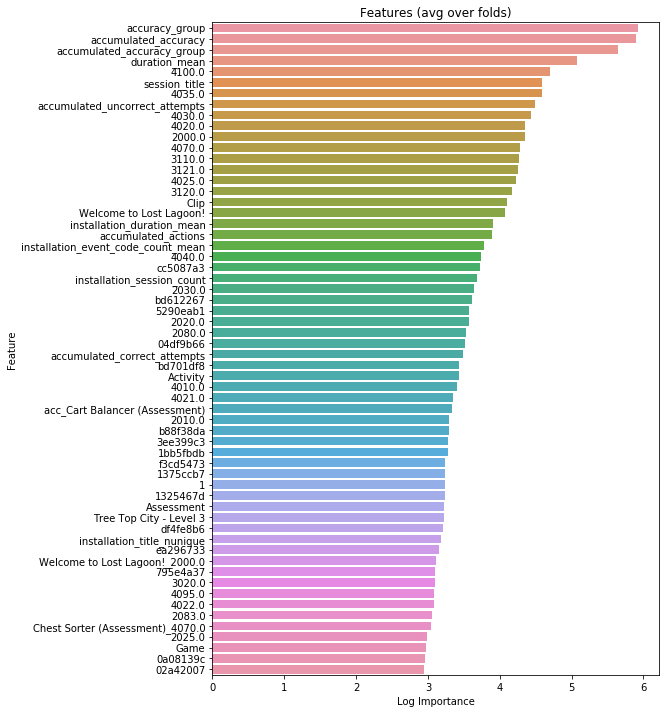

In [70]:
# Ploting feature importances
Importances['Log Importance'] = np.log1p(Importances['Importance'])
plt.figure(figsize=(8, 12))
sns.barplot(x="Log Importance", y="Feature", data=Importances.sort_values(by="Importance", ascending=False))
plt.title('Features (avg over folds)')